LQR

C:\Users\james\AppData\Local\Temp\ipykernel_3896\773166340.py:47: RuntimeWarning: overflow encountered in matmul
  Pdot = A.T@P + P@A - P@B@invR@B.T@P + Q
C:\Users\james\AppData\Local\Temp\ipykernel_3896\773166340.py:47: RuntimeWarning: invalid value encountered in matmul
  Pdot = A.T@P + P@A - P@B@invR@B.T@P + Q
C:\Users\james\AppData\Local\Temp\ipykernel_3896\773166340.py:101: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  U[i] = u


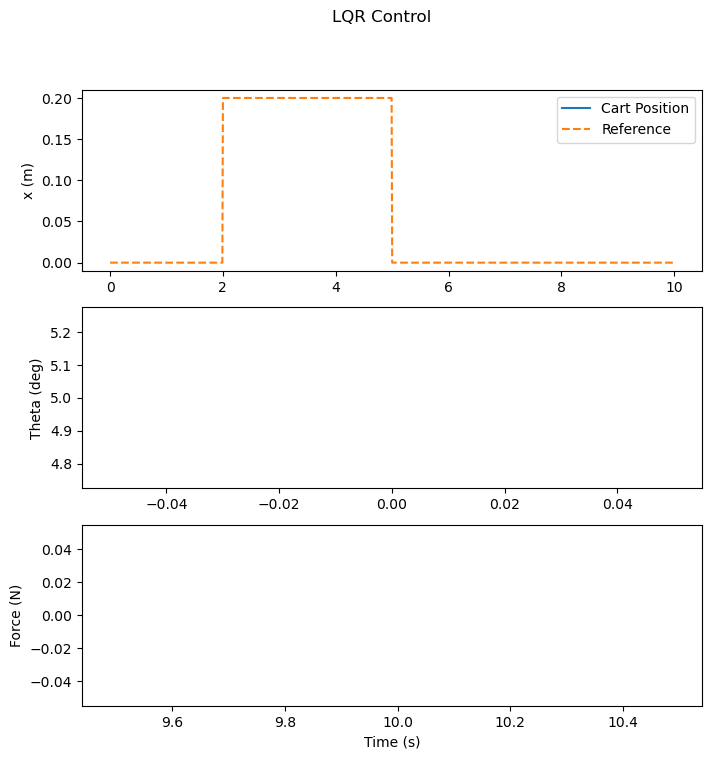

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#-----------------------------------
# System Matrices
#-----------------------------------
mc = 0.5
mp = 0.2
b  = 0.1
l  = 0.3
g  = 9.81
I  = 0.006
D  = (mc+mp)*I + mc*mp*l*l

A = np.array([
    [0, 1, 0, 0],
    [0, -(I+mp*l*l)*b/D, (mp*mp*g*l*l)/D, 0],
    [0, 0, 0, 1],
    [0, -mp*l*b/D, mp*g*l*(mc+mp)/D, 0]
])
B = np.array([
    [0],
    [(I+mp*l*l)/D],
    [0],
    [mp*l/D]
])

#-----------------------------------
# LQR parameters
#-----------------------------------
Q = np.diag([10, 1, 100, 1])  # penalize x1 heavily, and especially theta
R = np.array([[0.1]])

#-----------------------------------
# Solve CARE iteratively
#-----------------------------------
def solve_care_iter(A, B, Q, R, max_iter=10000, dt=0.001):
    """
    Naive method: treat P-dot = A^T P + P A - P B R^-1 B^T P + Q = 0
    and integrate forward in negative time until it converges.
    dt is a pseudo-time step for the iteration.
    """
    n = A.shape[0]
    P = np.eye(n)
    invR = np.linalg.inv(R)
    for _ in range(max_iter):
        Pdot = A.T@P + P@A - P@B@invR@B.T@P + Q
        # Move P in the direction that drives Pdot to zero:
        P_next = P - dt * Pdot
        # check difference
        if np.linalg.norm(P_next - P, ord='fro') < 1e-8:
            P = P_next
            break
        P = P_next
    return P

P = solve_care_iter(A, B, Q, R, max_iter=200000, dt=0.0001)
K = np.linalg.inv(R) @ B.T @ P

#-----------------------------------
# Simulation parameters
#-----------------------------------
dt = 0.01
t_final = 10.0
time = np.arange(0, t_final, dt)

# reference for cart position
def x_ref(t):
    if t < 2:
        return 0.0
    elif t < 5:
        return 0.2
    else:
        return 0.0

# initial state: 5 deg offset in pendulum
x0 = np.array([0.0, 0.0, 5.0*np.pi/180, 0.0])

# Storage
X = np.zeros((len(time), 4))
U = np.zeros(len(time))
X[0,:] = x0

#-----------------------------------
# Forward Euler simulation
#-----------------------------------
for i in range(len(time)-1):
    # form error-based state
    state = X[i,:].copy()
    state[0] -= x_ref(time[i])  # subtract reference from x1
    
    # control law
    u = -K @ state
    
    # state derivative
    xdot = A @ X[i,:] + B.flatten()*u
    
    # euler step
    X[i+1,:] = X[i,:] + xdot*dt
    
    U[i] = u

#-----------------------------------
# Plot
#-----------------------------------
plt.figure(figsize=(8,8))
plt.subplot(3,1,1)
plt.plot(time, X[:,0], label='Cart Position')
plt.plot(time, [x_ref(ti) for ti in time], '--', label='Reference')
plt.legend()
plt.ylabel('x (m)')

plt.subplot(3,1,2)
plt.plot(time, X[:,2]*180/np.pi, label='Pendulum Angle')
plt.ylabel('Theta (deg)')

plt.subplot(3,1,3)
plt.plot(time, U, label='Control Input (Force)')
plt.ylabel('Force (N)')
plt.xlabel('Time (s)')

plt.suptitle('LQR Control')
plt.show()


MPC

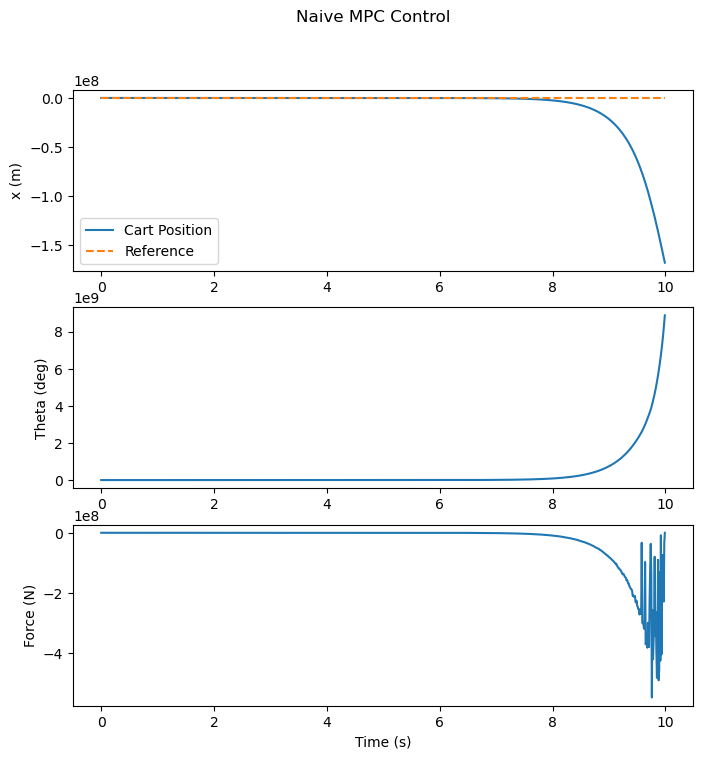

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Same system:
mc = 0.5
mp = 0.2
b  = 0.1
l  = 0.3
g  = 9.81
I  = 0.006
D  = (mc+mp)*I + mc*mp*l*l

A = np.array([
    [0, 1, 0, 0],
    [0, -(I+mp*l*l)*b/D, (mp*mp*g*l*l)/D, 0],
    [0, 0, 0, 1],
    [0, -mp*l*b/D, mp*g*l*(mc+mp)/D, 0]
])
B = np.array([
    [0],
    [(I+mp*l*l)/D],
    [0],
    [mp*l/D]
])

dt = 0.01
A_d = np.eye(4) + A*dt
B_d = B*dt

# MPC horizon
N = 10  # steps in the future

Q = np.diag([10, 1, 100, 1])
R = np.array([[0.1]])
Qf = Q  # final cost same as Q for simplicity

# Precompute "big matrices" for standard MPC form
# x_{k+1} = A_d x_k + B_d u_k
# We'll build block matrices for the cost.

# For a simpler approach, we can do a function that, given x(k),
# tries a naive open-loop forward simulation of control sequence U,
# and returns cost + gradient. Then we do a simple gradient-based
# solve (like gradient descent) each time step.

def simulate_system(x0, U):
    """
    x0: 4-dim initial state
    U: length-N array of control inputs
    returns the state trajectory [x0, x1, ..., xN], cost
    """
    x_seq = []
    x = x0.copy()
    cost = 0.0
    for k in range(N):
        x_seq.append(x)
        cost += x.T @ Q @ x + U[k]**2 * R[0,0]
        # step
        x = A_d @ x + B_d.flatten()*U[k]
    # final cost
    cost += x.T @ Qf @ x
    x_seq.append(x)
    return np.array(x_seq), cost

def compute_cost_and_grad(x0, U):
    """
    Numerically compute cost and gradient w.r.t. U using finite differences.
    """
    _, base_cost = simulate_system(x0, U)
    grad = np.zeros_like(U)
    eps = 1e-5
    for i in range(len(U)):
        U_perturb = U.copy()
        U_perturb[i] += eps
        _, c_plus = simulate_system(x0, U_perturb)
        grad[i] = (c_plus - base_cost)/eps
    return base_cost, grad

def naive_mpc_step(x0, max_iter=100):
    """
    Solve the open-loop problem for horizon N from x0 using
    a naive gradient-descent approach. Return the first control.
    """
    # initial guess
    U = np.zeros(N)
    alpha = 0.01  # step size
    for _ in range(max_iter):
        cost, grad = compute_cost_and_grad(x0, U)
        U_next = U - alpha*grad
        # if improvement is small, break
        if np.linalg.norm(U_next - U) < 1e-5:
            U = U_next
            break
        U = U_next
    return U[0]  # return the first control

# reference function
def x_ref(t):
    if t < 2:
        return 0.0
    elif t < 5:
        return 0.2
    else:
        return 0.0

# We'll do a simple approach: 
# subtract the reference from x1 in the state so that x1-> x1 - x_ref(t).
# This is not a perfect offset-free approach, but good enough for demonstration.

t_final = 10
time = np.arange(0, t_final, dt)
x0 = np.array([0, 0, 5*np.pi/180, 0])
X = np.zeros((len(time), 4))
U = np.zeros(len(time))
X[0,:] = x0

for i in range(len(time)-1):
    # Build a "reference-adjusted" state
    current_x = X[i,:].copy()
    current_x[0] -= x_ref(time[i])
    
    # Solve MPC
    u_star = naive_mpc_step(current_x)
    
    # apply to real system
    xdot = A @ X[i,:] + B.flatten()*u_star
    X[i+1,:] = X[i,:] + xdot*dt
    U[i] = u_star

# Plot
plt.figure(figsize=(8,8))
plt.subplot(3,1,1)
plt.plot(time, X[:,0], label='Cart Position')
plt.plot(time, [x_ref(ti) for ti in time], '--', label='Reference')
plt.ylabel('x (m)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(time, X[:,2]*180/np.pi)
plt.ylabel('Theta (deg)')

plt.subplot(3,1,3)
plt.plot(time, U)
plt.ylabel('Force (N)')
plt.xlabel('Time (s)')
plt.suptitle('Naive MPC Control')
plt.show()
